In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from tqdm import tqdm

from qtt.algorithms.functions import (gauss_ramsey, fit_gauss_ramsey, 
                                      plot_gauss_ramsey_fit)
from qutip import (basis, tensor, sigmaz, sigmax, sigmaz, sigmam, sigmap, 
                   mesolve, identity, Qobj, destroy, qeye, expect, parallel_map)

from qubit_zz_coupling.core import (setup_operators, solve_t1, solve_t2,
                                    plot_t1, plot_t2, rabi_results, make_n,
                                    ramsey_expectation_drive_both,
                                    ramsey_population_drive_both,
                                    ramsey_expectation_drive_sep,
                                    ramsey_population_drive_sep,
                                    make_3tensor, ramsey_result,
                                    ramsey_result_multiplex,
                                    rabi_results_multiplex)
from qubit_zz_coupling.utils import  f2w, fq_shift, make_population, ramsey


In [2]:
import sys

sys._is_gil_enabled()

AttributeError: module 'sys' has no attribute '_is_gil_enabled'

In [66]:
USE_MP = True # Depends on system

# Define system parameters
SYSTEM_PARAMS_base = {
    "f_q1": 3.200,  # GHz, Qubit 1 frequency (3.2)
    "f_q2": 3.350,  # GHz, Qubit 2 frequency
    "f_tls": 3.200,  # GHz, TLS frequency (resonant with Qubit 1)
    "T1": {"q1": 20000, "q2": 250000, "tls": 1e8},  # Relaxation rates 200
    "T2": {"q1": 15000, "q2": 180000, "tls": 1e8},  # Dephasing rates 150
    "J_zz": 0.01, # Jzz coupling
    "J_tls": 0.01,  # GHz, Coupling strength between Qubit 1 and TLS
    "omega1": 2*np.pi * 0.01, # drive amplitude (sets π/2 duration)
    "omega2": 2*np.pi * 0.01, # drive amplitude (sets π/2 duration)
    "time_points": np.linspace(0, 300, 105),  # Time points in μs
    "ver1": True,
    "single": False
}

opts = {"nsteps": 1000000, "store_final_state":True, "atol":1e-10,"rtol":1e-8}

# Ramsey Oscillation

In [67]:
# Get fresh settings
SYSTEM_PARAMS = SYSTEM_PARAMS_base.copy()

w_q1 = f2w(SYSTEM_PARAMS["f_q1"])
w_d = w_q1 + f2w(0.042)
omega = SYSTEM_PARAMS["omega1"]

# Example sweep
taus      = np.linspace(0, 4000, 64)
t_p = np.pi / (2*SYSTEM_PARAMS["omega1"])


H, c_ops, sz_q1, sz_q2, sx_q1, sx_q2, sm_q1, sm_q2 = setup_operators(SYSTEM_PARAMS)

def pm(t):
    res_psi = ramsey_result(t, w_d, t_p, omega, H, sx_q1, c_ops, opts=opts, psi0=make_3tensor(1,0,0), step=1)
    n = make_n(sm_q1)
    res = expect(n, res_psi)
    return res 

if  USE_MP:
    vals = list(parallel_map(pm,taus,progress_bar=True))
else:
    vals = [pm(tau) for tau in taus]


10.9%. Run time:   1.33s. Est. time left: 00:00:00:10
20.3%. Run time:   1.70s. Est. time left: 00:00:00:06
31.2%. Run time:   2.34s. Est. time left: 00:00:00:05
40.6%. Run time:   2.54s. Est. time left: 00:00:00:03
50.0%. Run time:   2.96s. Est. time left: 00:00:00:02
60.9%. Run time:   3.29s. Est. time left: 00:00:00:02
70.3%. Run time:   3.45s. Est. time left: 00:00:00:01
81.2%. Run time:   3.66s. Est. time left: 00:00:00:00
90.6%. Run time:   4.00s. Est. time left: 00:00:00:00
100.0%. Run time:   4.40s. Est. time left: 00:00:00:00
Total run time:   4.47s


Text(0, 0.5, 'Population')

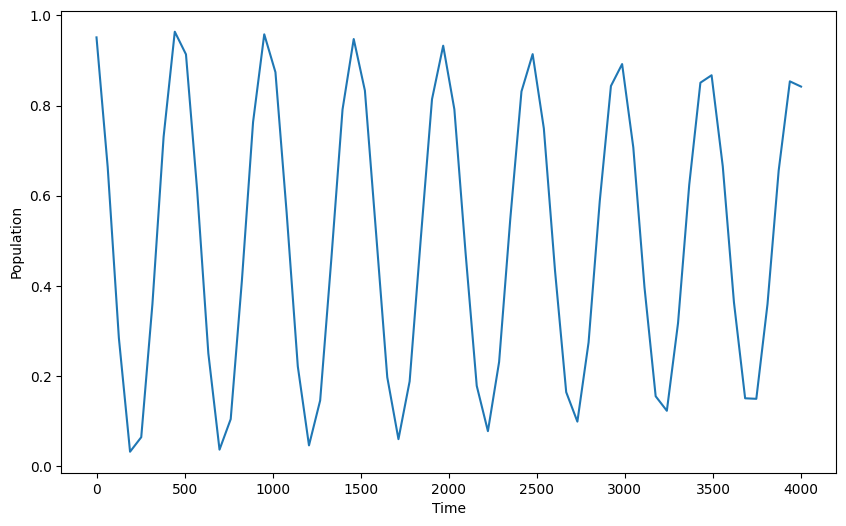

In [68]:
fig, axes = plt.subplots(1, 1, figsize=(10,6))

#axes.scatter(t[i],res[i],color="red") #pi pulse peak
axes.plot(taus, vals)
axes.set_xlabel('Time')
axes.set_ylabel('Population')
#axes.set_title(f'Rabi Oscillation pulse={pi_pulse:.3f}');

In [69]:
# Get fresh settings
SYSTEM_PARAMS = SYSTEM_PARAMS_base.copy()

w_q1 = f2w(SYSTEM_PARAMS["f_q1"])
omega = SYSTEM_PARAMS["omega1"]

# Example sweep
#taus      = np.linspace(0, 200, 201)
t_p = np.pi / (2 * SYSTEM_PARAMS["omega1"])

H, c_ops, sz_q1, sz_q2, sx_q1, sx_q2, sm_q1, sm_q2 = setup_operators(SYSTEM_PARAMS)

def pm(arg):
    res_psi = ramsey_result(arg[0], arg[1], t_p, omega, H, sx_q1, c_ops, opts=opts, psi0=make_3tensor(1,0,0))
    n = make_n(sm_q1)
    res = expect(n, res_psi)
    return res 

# interrogation times and detunings
T=np.linspace(0,4000,128) # ns 128
Det_p=np.linspace(0.038,0.042,72) # GHz 72
Det=f2w(Det_p)+w_q1 # GHz

# generates pairs for each coordinate and puts them in a 1D list
T,Det=np.meshgrid(T,Det)
pairs=np.array([T.flatten(),Det.flatten()]).T

if  USE_MP:
    vals = list(parallel_map(pm,pairs,progress_bar=True))
else:
    vals = [pm(pair) for pair in pairs]

# reshapes the list of results into a matrix
rmap=np.array(vals).reshape(T.shape)

10.0%. Run time:  33.98s. Est. time left: 00:00:05:05
20.0%. Run time:  66.27s. Est. time left: 00:00:04:24
30.0%. Run time:  98.98s. Est. time left: 00:00:03:50
40.0%. Run time: 131.45s. Est. time left: 00:00:03:17
50.0%. Run time: 164.45s. Est. time left: 00:00:02:44
60.0%. Run time: 197.30s. Est. time left: 00:00:02:11
70.0%. Run time: 230.08s. Est. time left: 00:00:01:38
80.0%. Run time: 262.59s. Est. time left: 00:00:01:05
90.0%. Run time: 295.16s. Est. time left: 00:00:00:32
100.0%. Run time: 328.73s. Est. time left: 00:00:00:00
Total run time: 328.97s


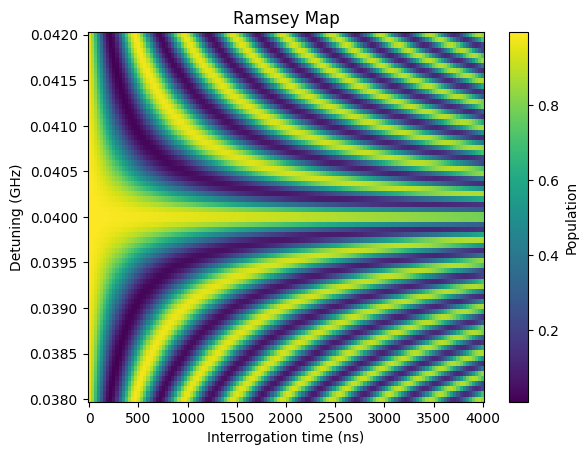

In [70]:

# prompt: Plot exp pcolor map with T and Det as axis


# Assuming T and Det and exp are defined from the previous code block
plt.pcolormesh(T, Det_p, rmap)
plt.xlabel("Interrogation time (ns)")
plt.ylabel("Detuning (GHz)")
plt.title("Ramsey Map")
plt.colorbar(label="Population")
plt.show()

# Multiplex drive

In [75]:
# Get fresh settings
SYSTEM_PARAMS = SYSTEM_PARAMS_base.copy()

w_q1 = f2w(SYSTEM_PARAMS["f_q1"])
w_q2 = f2w(SYSTEM_PARAMS["f_q2"])

w_d = w_q1 + f2w(0.00)
omega = SYSTEM_PARAMS["omega1"]

# Example sweep
taus      = np.linspace(0, 200, 201)
t_p = np.pi / (2 * SYSTEM_PARAMS["omega1"])

H, c_ops, sz_q1, sz_q2, sx_q1, sx_q2, sm_q1, sm_q2 = setup_operators(SYSTEM_PARAMS)

def pm(arg):
    res_psi = ramsey_result_multiplex(arg[0], arg[1],  w_q2+f2w(0.0), t_p, omega, H, sx_q1, sx_q2, c_ops, opts=opts, psi0=make_3tensor(1,0,0))
    n = make_n(sm_q1)
    res = expect(n, res_psi)
    return res 

# interrogation times and detunings
T=np.linspace(0,4000,128) # ns
Det_p=np.linspace(0.038,0.042,72) # GHz
Det=f2w(Det_p)+w_q1 # GHz

# generates pairs for each coordinate and puts them in a 1D list
T,Det=np.meshgrid(T,Det)
pairs=np.array([T.flatten(),Det.flatten()]).T

if  USE_MP:
    vals = list(parallel_map(pm,pairs,progress_bar=True))
else:
    vals = [pm(pair) for pair in pairs]

# reshapes the list of results into a matrix
rmap=np.array(vals).reshape(T.shape)

10.0%. Run time:  68.21s. Est. time left: 00:00:10:13
20.0%. Run time: 135.26s. Est. time left: 00:00:09:00
30.0%. Run time: 202.44s. Est. time left: 00:00:07:52
40.0%. Run time: 269.84s. Est. time left: 00:00:06:44
50.0%. Run time: 337.65s. Est. time left: 00:00:05:37
60.0%. Run time: 405.72s. Est. time left: 00:00:04:30
70.0%. Run time: 473.46s. Est. time left: 00:00:03:22
80.0%. Run time: 540.61s. Est. time left: 00:00:02:15
90.0%. Run time: 608.09s. Est. time left: 00:00:01:07
100.0%. Run time: 676.97s. Est. time left: 00:00:00:00
Total run time: 677.21s


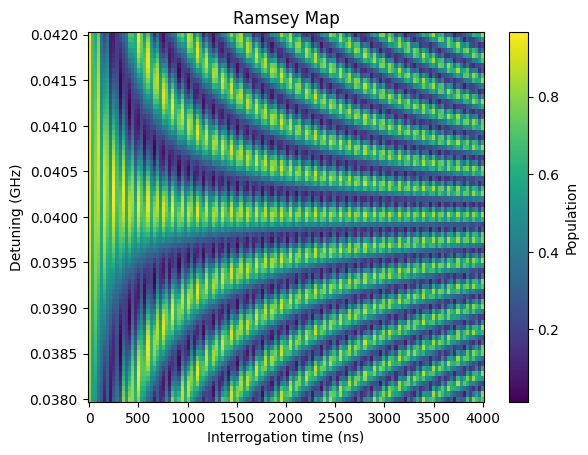

In [76]:
# prompt: Plot exp pcolor map with T and Det as axis


# Assuming T and Det and exp are defined from the previous code block
plt.pcolormesh(T, Det_p, rmap)
plt.xlabel("Interrogation time (ns)")
plt.ylabel("Detuning (GHz)")
plt.title("Ramsey Map")
plt.colorbar(label="Population")
plt.show()